 # AI305-Introduction to Machine Learning

### NBA Player Performance Analysis: Course Project Fall 2025

#### Importing the Liberies 

In [10]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc,
    silhouette_score, davies_bouldin_score
)

from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import joblib

os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

####  Loading Data + Feature Engineering

In [11]:

DATA_PATH = 'nba_data.csv'  

df_raw = pd.read_csv(DATA_PATH)
print("Raw data shape:", df_raw.shape)
display(df_raw.head())


def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
# Prepare engineered features according to Phase 1:
#   - FG%, FT%
#   - Usage_Rate
#   - Shooting_Eff (custom efficiency)
#   - ATR (Assist-to-Turnover Ratio)

    df = df.copy()

    # Field goal percentage (if not already present or to re-compute safely)
    if 'FGA' in df.columns and 'FGM' in df.columns:
        df['FG%'] = df['FGM'] / df['FGA'].replace(0, np.nan)

    # Free throw percentage
    if 'FTA' in df.columns and 'FTM' in df.columns:
        df['FT%'] = df['FTM'] / df['FTA'].replace(0, np.nan)

    # Usage rate approximation (Roaa) – shots per minute as a simple proxy
    if 'FGA' in df.columns and 'MP' in df.columns:
        df['Usage_Rate'] = df['FGA'] / df['MP'].replace(0, np.nan)

    # Shooting efficiency SE (Joudi) – Phase 1 formula:
    # SE = PTS / (FGA + 0.44 * FTA)
    if {'PTS', 'FGA', 'FTA'}.issubset(df.columns):
        denom = (df['FGA'] + 0.44 * df['FTA']).replace(0, np.nan)
        df['Shooting_Eff'] = df['PTS'] / denom

    # Assist-to-turnover ratio ATR (Wajd)
    if 'AST' in df.columns and 'TOV' in df.columns:
        df['ATR'] = df['AST'] / df['TOV'].replace(0, np.nan)

    # Replace infinities and NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)

    return df


df_feat = prepare_features(df_raw)
print("Prepared feature data shape:", df_feat.shape)
display(df_feat.head())

Raw data shape: (16512, 25)


,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,...,4,4,10,1,1,1,1,37,38.1,2024-10-22
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,...,13,16,4,1,3,1,1,36,34.0,2024-10-22
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,...,3,3,4,1,0,0,1,24,22.4,2024-10-22
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,...,2,4,4,1,0,0,2,18,19.5,2024-10-22
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,...,0,0,2,0,0,1,1,22,17.8,2024-10-22


Prepared feature data shape: (16512, 28)


,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,...,STL,BLK,TOV,PF,PTS,GmSc,Data,Usage_Rate,Shooting_Eff,ATR
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,...,1,1,1,1,37,38.1,2024-10-22,0.594059,1.959746,10.0
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,...,1,3,1,1,36,34.0,2024-10-22,0.612028,1.216216,4.0
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,...,1,0,0,1,24,22.4,2024-10-22,0.488171,1.729107,0.0
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,...,1,0,0,2,18,19.5,2024-10-22,0.294889,2.000000,0.0
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,...,0,0,1,1,22,17.8,2024-10-22,0.386847,1.943463,2.0


####  Model Evaluation & Visualization Module

In [12]:
def evaluate_regression(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }


def evaluate_classification(y_true, y_pred, model=None, X_test=None, proba=None):
    metrics_dict = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }

    if proba is not None:
        try:
            metrics_dict['roc_auc'] = roc_auc_score(y_true, proba)
        except Exception:
            metrics_dict['roc_auc'] = np.nan
    else:
        metrics_dict['roc_auc'] = np.nan

    return metrics_dict


def plot_roc_curve_simple(y_true, y_proba, title, filename=None):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join('plots', filename))
    plt.show()


def plot_confusion_matrix_simple(y_true, y_pred, title, filename=None):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Loss', 'Win'])
    plt.yticks(tick_marks, ['Loss', 'Win'])

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join('plots', filename))
    plt.show()


def plot_clusters_2d(df, x_col, y_col, cluster_col, title, filename=None):
    plt.figure(figsize=(7, 5))
    for c in sorted(df[cluster_col].unique()):
        subset = df[df[cluster_col] == c]
        plt.scatter(subset[x_col], subset[y_col], label=f'Cluster {c}', s=40, alpha=0.7)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join('plots', filename))
    plt.show()


def get_feature_sets(df, target_col):
    df_num = df.select_dtypes(include=[np.number]).copy()
    if target_col not in df_num.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric or convertible.")

    y = df_num[target_col].values
    X = df_num.drop(columns=[target_col])

    return X, y


#### Task 1: Player Performance Prediction (Regression)

In [13]:
# Wajd: Linear Regression
def train_linear_regression_wajd(X_train_scaled, X_test_scaled, y_train, y_test):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)
    preds_lin = lin_reg.predict(X_test_scaled)
    metrics_lin = evaluate_regression(y_test, preds_lin)
    return lin_reg, metrics_lin


# Joudi: Random Forest Regressor
def train_rf_regression_joudi(X_train, X_test, y_train, y_test):
    rf_reg = RandomForestRegressor(
        n_estimators=200,
        random_state=42
    )
    rf_reg.fit(X_train, y_train)
    preds_rf = rf_reg.predict(X_test)
    metrics_rf = evaluate_regression(y_test, preds_rf)
    return rf_reg, metrics_rf


# Roaa: MLP Regressor
def train_mlp_regression_roaa(X_train_scaled, X_test_scaled, y_train, y_test):
    mlp_reg = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        random_state=42
    )
    mlp_reg.fit(X_train_scaled, y_train)
    preds_mlp = mlp_reg.predict(X_test_scaled)
    metrics_mlp = evaluate_regression(y_test, preds_mlp)
    return mlp_reg, metrics_mlp


def run_regressions(df, target_col='PTS'):

# Task 1: Regression – predict a numeric target e.g., PTS)
# Uses Linear Regression (Wajd), Random Forest (Joudi), MLPRegressor (Roaa)
    print('\n ___________ Task 1: Regression ___________')
    df = df.copy()
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe.")

    X, y = get_feature_sets(df, target_col=target_col)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

 # Linear Regression Wajd
    lin_reg, res_lin = train_linear_regression_wajd(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    results['LinearRegression'] = res_lin

# Random Forest Regressor Joudi
    rf_reg, res_rf = train_rf_regression_joudi(
        X_train, X_test, y_train, y_test
    )
    results['RandomForestRegressor'] = res_rf

 # Regressor Roaa
    mlp_reg, res_mlp = train_mlp_regression_roaa(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    results['MLPRegressor'] = res_mlp

# Save models & scaler
    joblib.dump(scaler, 'models/reg_scaler.pkl')
    joblib.dump(lin_reg, 'models/lin_reg.pkl')
    joblib.dump(rf_reg, 'models/rf_reg.pkl')
    joblib.dump(mlp_reg, 'models/mlp_reg.pkl')

    print("\nRegression results:")
    for name, m in results.items():
        print(
            f"{name}: "
            f"MSE={m['MSE']:.3f}, RMSE={m['RMSE']:.3f}, "
            f"MAE={m['MAE']:.3f}, R2={m['R2']:.3f}"
        )

    return results
reg_results = run_regressions(df_feat, target_col='PTS')


 ___________ Task 1: Regression ___________

Regression results:
LinearRegression: MSE=0.000, RMSE=0.000, MAE=0.000, R2=1.000
RandomForestRegressor: MSE=0.099, RMSE=0.315, MAE=0.070, R2=0.999
MLPRegressor: MSE=0.001, RMSE=0.036, MAE=0.028, R2=1.000


#### Task 2 : Style Clustering (Unsupervised Learning)


 ___________ Task 2: Clustering ___________
Aggregating per-player averages for clustering...


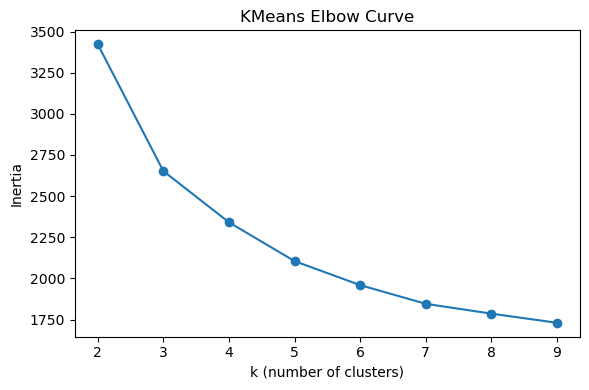

Elbow curve saved to plots/kmeans_elbow.png

KMeans cluster counts:
cluster_km
0    168
1     91
2    168
3     51
4     84
Name: count, dtype: int64

Agglomerative cluster counts:
cluster_agglom
0    176
1     46
2     71
3    178
4     91
Name: count, dtype: int64

Cluster statistical profiles (KMeans):

Cluster statistical profiles (KMeans):


,PTS,AST,TRB,STL,BLK,FGA,3PA,FT%,Usage_Rate,Shooting_Eff
cluster_km,,,,,,,,,,
0,9.63,2.27,3.60,0.87,0.34,7.82,3.83,0.41,0.34,1.09
1,20.74,4.91,5.62,1.15,0.53,15.91,6.32,0.70,0.48,1.16
2,4.07,0.99,2.24,0.40,0.27,3.38,1.51,0.22,0.30,0.98
3,11.70,2.05,7.91,0.80,1.31,8.67,1.92,0.51,0.33,1.18
4,1.23,0.42,0.96,0.16,0.08,1.35,0.70,0.08,0.24,0.43



Assigned cluster names:
Cluster 0: Supporting Guards 
Cluster 1: Elite Scorers
Cluster 2: Role Players
Cluster 3: Defensive Specialists 
Cluster 4: Low-Usage Bench Players

Cluster quality for k=5: Silhouette=0.218, Davies-Bouldin=1.332
KMeans centers saved to models/kmeans_centers.csv


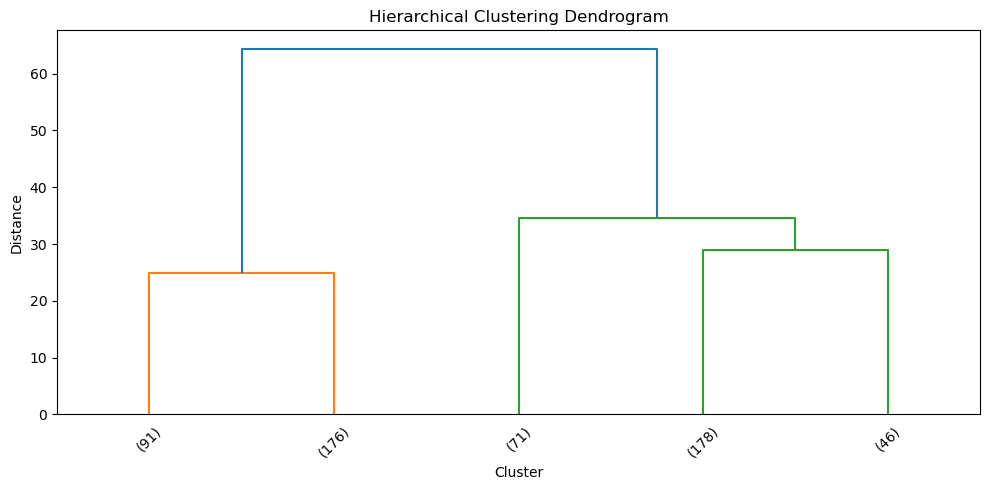

Dendrogram saved to plots/hierarchical_dendrogram.png


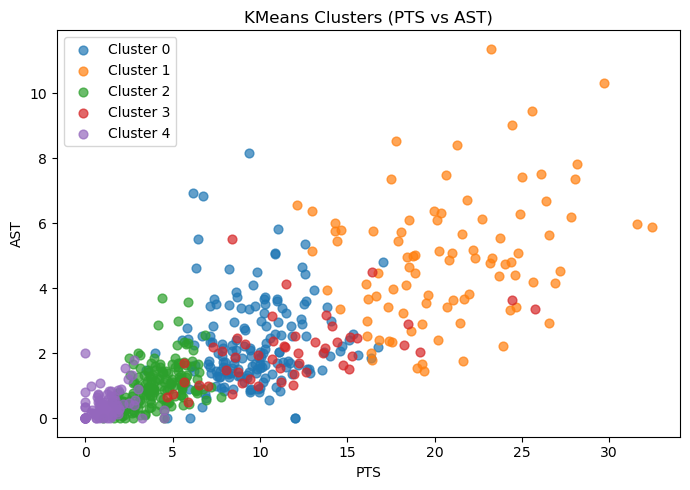

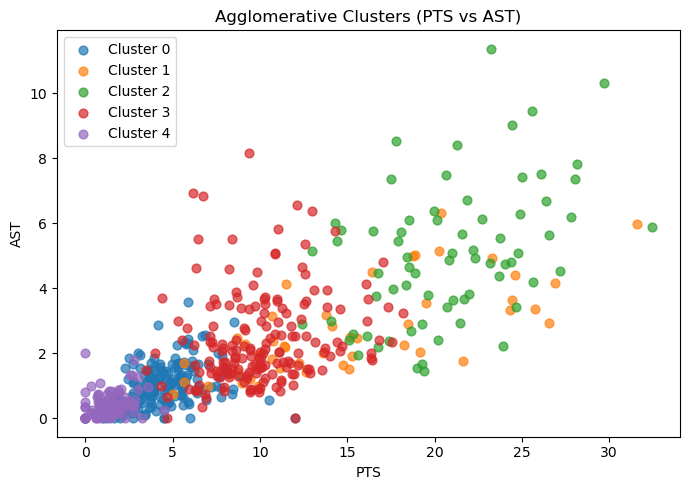

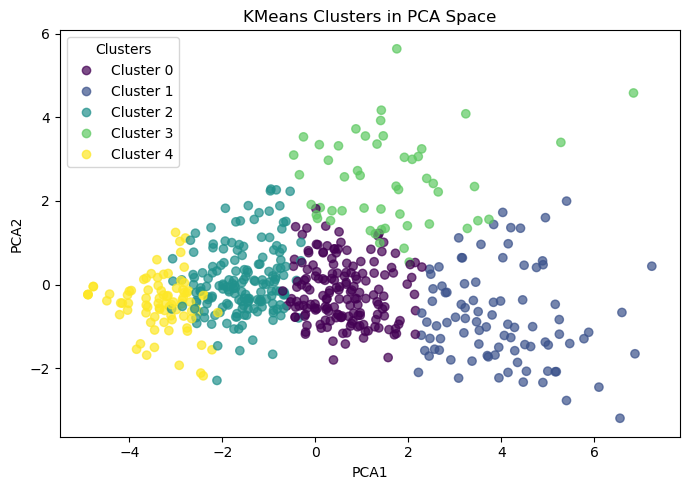

PCA cluster plot saved to plots/kmeans_pca_clusters.png


,Player,PTS,cluster_km,cluster_agglom,cluster_name
0,A.J. Green,7.659091,0,0,Supporting Guards
1,A.J. Lawson,2.750000,2,0,Role Players
2,AJ Johnson,2.444444,4,0,Low-Usage Bench Players
3,Aaron Gordon,12.333333,0,3,Supporting Guards
4,Aaron Holiday,4.222222,2,0,Role Players


In [14]:
def run_clustering(df, n_clusters=5, use_player_average=True):
    print('\n ___________ Task 2: Clustering ___________')

# Choose features
    features = ['PTS', 'AST', 'TRB', 'STL', 'BLK',
                'FGA', '3PA', 'FT%', 'Usage_Rate', 'Shooting_Eff']
    features = [f for f in features if f in df.columns]
    if len(features) < 2:
        raise ValueError("Not enough features for clustering; adjust the feature list.")


# Aggregate to per-player averages (requirement)
    if use_player_average and 'Player' in df.columns:
        print("Aggregating per-player averages for clustering...")
        df_cluster = df.groupby('Player', as_index=False)[features].mean()
    else:
        print("Using raw rows (no per-player aggregation).")
        if 'Player' in df.columns:
            df_cluster = df[['Player'] + features].copy()
        else:
            df_cluster = df[features].copy()

# Prepare X and scale 
    X = df_cluster[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

# Elbow method for KMeans
    inertias = []
    ks = list(range(2, min(10, len(df_cluster))))
    if len(ks) > 0:
        for k in ks:
            km = KMeans(n_clusters=k, random_state=42)
            km.fit(X_scaled)
            inertias.append(km.inertia_)
        plt.figure(figsize=(6, 4))
        plt.plot(ks, inertias, marker='o')
        plt.xlabel('k (number of clusters)')
        plt.ylabel('Inertia')
        plt.title('KMeans Elbow Curve')
        plt.tight_layout()
        plt.savefig('plots/kmeans_elbow.png')
        plt.show()
        print("Elbow curve saved to plots/kmeans_elbow.png")
    else:
        print("Not enough samples for elbow method.")

# KMeans & Agglomerative Clustering 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    k_labels = kmeans.fit_predict(X_scaled)

    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    a_labels = agglom.fit_predict(X_scaled)

    df_cluster['cluster_km'] = k_labels
    df_cluster['cluster_agglom'] = a_labels

    print('\nKMeans cluster counts:')
    print(df_cluster['cluster_km'].value_counts().sort_index())
    print('\nAgglomerative cluster counts:')
    print(df_cluster['cluster_agglom'].value_counts().sort_index())
    print('\nCluster statistical profiles (KMeans):')
    #  Interpretation + Naming
    print('\nCluster statistical profiles (KMeans):')
    cluster_summary = (
    df_cluster
    .groupby('cluster_km')[features]
    .mean()
    .round(2)
    )
    display(cluster_summary)

    cluster_names = {

    0: 'Supporting Guards ',
    1: 'Elite Scorers',
    2: 'Role Players',
    3: 'Defensive Specialists ',
    4: 'Low-Usage Bench Players'
}

    df_cluster['cluster_name'] = df_cluster['cluster_km'].map(cluster_names)

    print('\nAssigned cluster names:')
    for k, v in cluster_names.items():
        print(f'Cluster {k}: {v}')
    



# Additional cluster quality metrics (Silhouette & DBI)
    try:
        sil = silhouette_score(X_scaled, k_labels)
        dbi = davies_bouldin_score(X_scaled, k_labels)
        print(f'\nCluster quality for k={n_clusters}: '
              f'Silhouette={sil:.3f}, Davies-Bouldin={dbi:.3f}')
    except Exception as e:
        print("Could not compute silhouette/DBI:", e)

# Save KMeans cluster centers 
    try:
        centers = scaler.inverse_transform(kmeans.cluster_centers_)
        center_df = pd.DataFrame(centers, columns=features)
        center_df.index.name = 'cluster'
        center_df.to_csv('models/kmeans_centers.csv')
        print("KMeans centers saved to models/kmeans_centers.csv")
    except Exception as e:
        print("Could not save centers:", e)

# Hierarchical dendrogram
    try:
        Z = linkage(X_scaled, method='ward')
        plt.figure(figsize=(10, 5))
        dendrogram(
            Z,
            truncate_mode='lastp',
            p=n_clusters,
            leaf_rotation=45.,
            leaf_font_size=10.,
        )
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Cluster')
        plt.ylabel('Distance')
        plt.tight_layout()
        plt.savefig('plots/hierarchical_dendrogram.png')
        plt.show()
        print("Dendrogram saved to plots/hierarchical_dendrogram.png")
    except Exception as e:
        print("Could not plot dendrogram:", e)

# Simple 2D scatter (PTS vs AST or fallback) 
    numeric_cols = df_cluster.select_dtypes(include=[np.number]).columns.tolist()
    if 'PTS' in numeric_cols and 'AST' in numeric_cols:
        x_col, y_col = 'PTS', 'AST'
    else:
        if len(numeric_cols) < 2:
            print("Not enough numeric columns for plotting.")
            return df_cluster
        x_col, y_col = numeric_cols[0], numeric_cols[1]

    plot_clusters_2d(
        df_cluster, x_col, y_col, 'cluster_km',
        f'KMeans Clusters ({x_col} vs {y_col})'
    )
    plot_clusters_2d(
        df_cluster, x_col, y_col, 'cluster_agglom',
        f'Agglomerative Clusters ({x_col} vs {y_col})'
    )

# PCA 2D visualization
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        df_cluster['PCA1'] = X_pca[:, 0]
        df_cluster['PCA2'] = X_pca[:, 1]

        plt.figure(figsize=(7, 5))
        scatter = plt.scatter(
            df_cluster['PCA1'],
            df_cluster['PCA2'],
            c=df_cluster['cluster_km'],
            alpha=0.7
        )
        plt.xlabel('PCA1')
        plt.ylabel('PCA2')
        plt.title('KMeans Clusters in PCA Space')
        handles, _ = scatter.legend_elements()
        plt.legend(handles, [f"Cluster {i}" for i in range(len(handles))], title="Clusters")
        plt.tight_layout()
        plt.savefig('plots/kmeans_pca_clusters.png')
        plt.show()
        print("PCA cluster plot saved to plots/kmeans_pca_clusters.png")
    except Exception as e:
        print("Could not compute PCA:", e)

    return df_cluster


df_clustered = run_clustering(df_feat, n_clusters=5)

if 'Player' in df_clustered.columns:
    display(df_clustered[['Player', 'PTS', 'cluster_km', 'cluster_agglom', 'cluster_name']].head())
else:
    display(df_clustered.head())



#### Task 3: Game Outcome Classification (W/L Prediction)


=== Task 3: Classification ===

Class distribution (0=loss, 1=win):
target_win
0    0.500545
1    0.499455
Name: proportion, dtype: float64


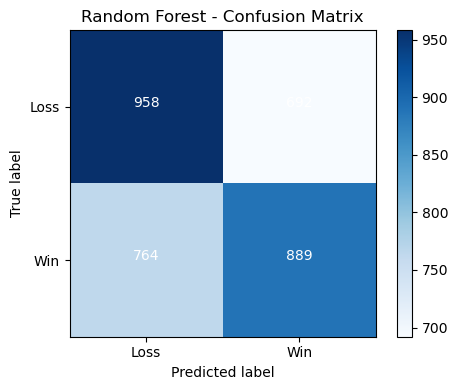

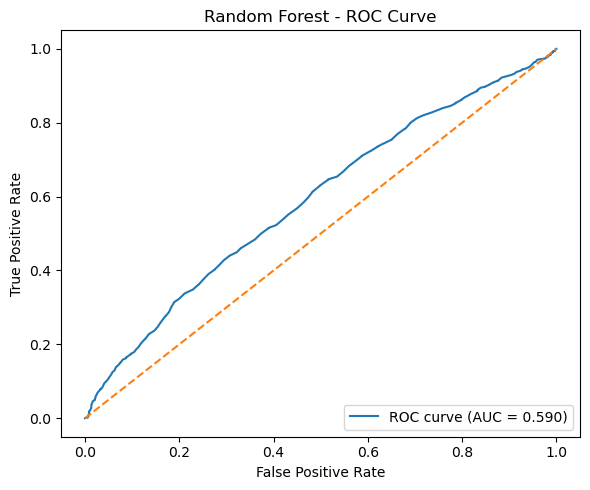


Best RF params from GridSearchCV: {'max_depth': None, 'n_estimators': 200}


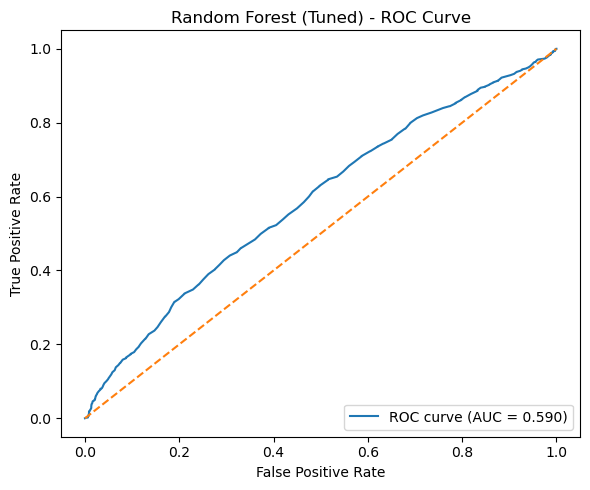

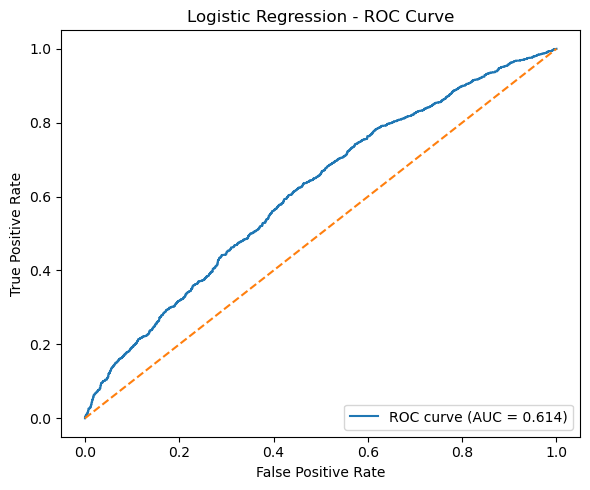

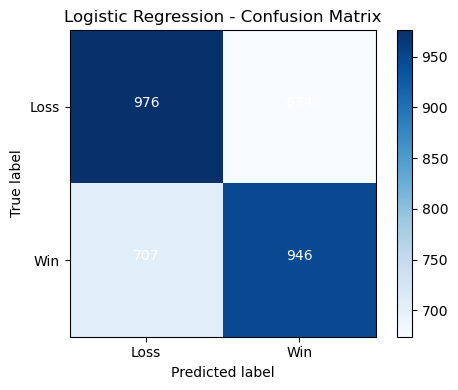

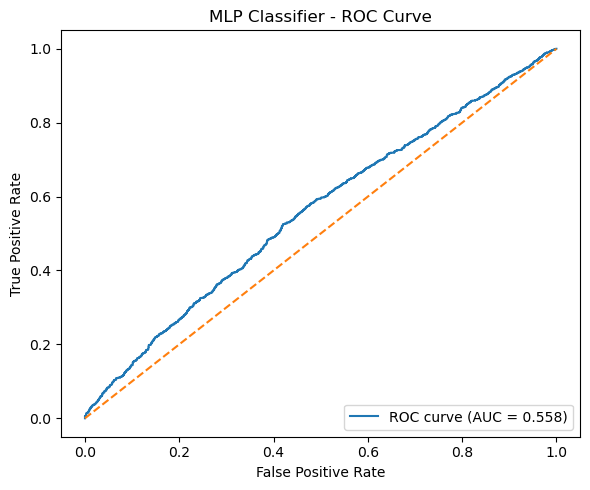

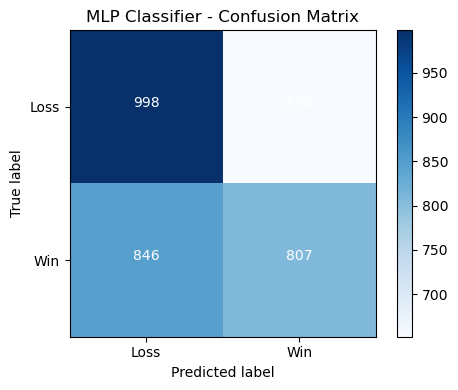

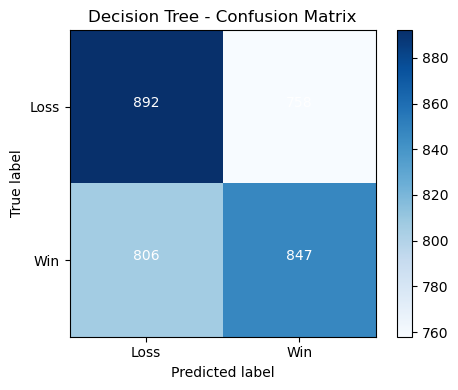

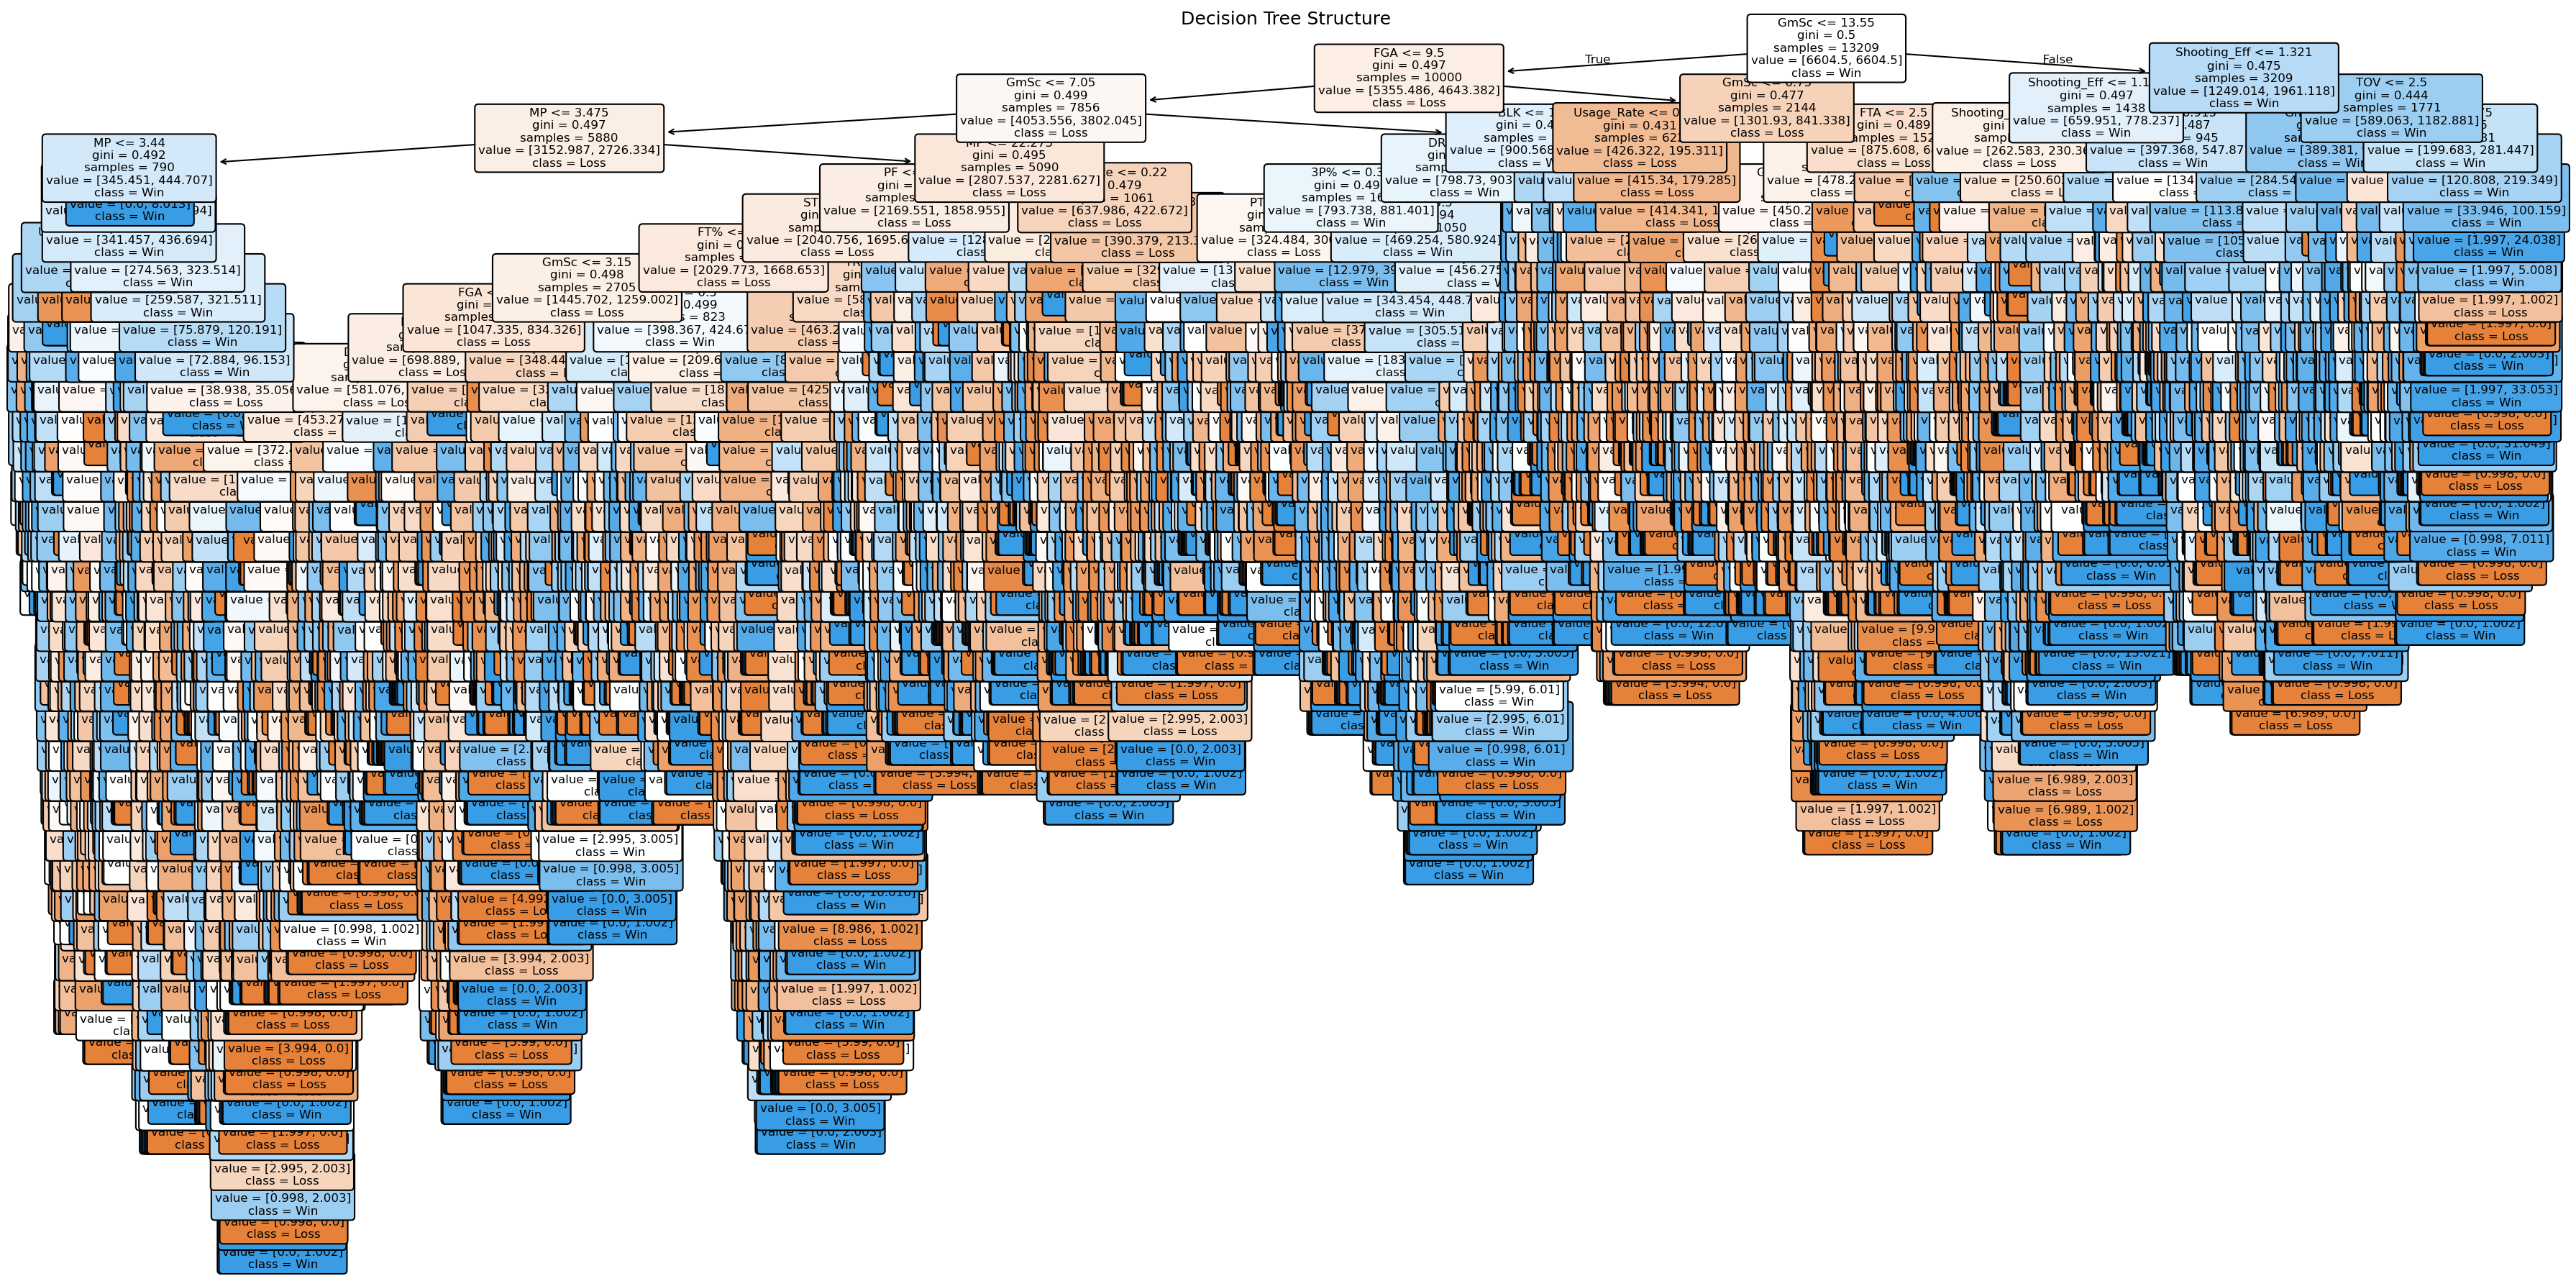

Decision tree structure saved to plots/decision_tree_structure.png

Classification results:
RandomForest: Acc=0.559, Prec=0.562, Rec=0.538, F1=0.550, ROC_AUC=0.590
RandomForest_Tuned: Acc=0.559, Prec=0.562, Rec=0.538, F1=0.550, ROC_AUC=0.590
LogisticRegression: Acc=0.582, Prec=0.584, Rec=0.572, F1=0.578, ROC_AUC=0.614
MLPClassifier: Acc=0.546, Prec=0.553, Rec=0.488, F1=0.519, ROC_AUC=0.558
DecisionTree: Acc=0.526, Prec=0.528, Rec=0.512, F1=0.520, ROC_AUC=nan


{'RandomForest': {'accuracy': 0.5591886164093248,
  'precision': 0.562302340290955,
  'recall': 0.5378100423472474,
  'f1': 0.5497835497835498,
  'roc_auc': 0.5900846944948578},
 'RandomForest_Tuned': {'accuracy': 0.5591886164093248,
  'precision': 0.562302340290955,
  'recall': 0.5378100423472474,
  'f1': 0.5497835497835498,
  'roc_auc': 0.5900846944948578},
 'LogisticRegression': {'accuracy': 0.581895246745383,
  'precision': 0.5839506172839506,
  'recall': 0.5722928009679371,
  'f1': 0.5780629391995111,
  'roc_auc': 0.6141742286751362},
 'MLPClassifier': {'accuracy': 0.5464729034211323,
  'precision': 0.5531185743660041,
  'recall': 0.4882032667876588,
  'f1': 0.5186375321336761,
  'roc_auc': 0.5582897944966911},
 'DecisionTree': {'accuracy': 0.5264910687254012,
  'precision': 0.5277258566978194,
  'recall': 0.5124016938898972,
  'f1': 0.519950890116636,
  'roc_auc': nan}}

In [15]:
# convert Res to binary 
def res_to_binary(x):
    if isinstance(x, str):
        if 'W' in x.upper():
            return 1
        if 'L' in x.upper():
            return 0
    try:
        return int(x)
    except Exception:
        return 0


# Wajd: Random Forest Classifier 
def train_rf_classifier_wajd(X_train, X_test, y_train, y_test):
    
    rfc = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    )
    rfc.fit(X_train, y_train)
    preds_rfc = rfc.predict(X_test)
    proba_rfc = rfc.predict_proba(X_test)[:, 1]

    metrics_rfc = evaluate_classification(y_test, preds_rfc, rfc, X_test, proba_rfc)

    plot_confusion_matrix_simple(
        y_test, preds_rfc, 'Random Forest - Confusion Matrix'
    )
    plot_roc_curve_simple(
        y_test, proba_rfc, 'Random Forest - ROC Curve'
    )

    return rfc, preds_rfc, proba_rfc, metrics_rfc


# Team Work: Tuned Random Forest with GridSearchCV
def tune_rf_classifier_team(X_train, X_test, y_train, y_test):
   
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10]
    }
    rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
    grid_rf = GridSearchCV(
        rf_base,
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1
    )
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    print("\nBest RF params from GridSearchCV:", grid_rf.best_params_)

    preds_rf_tuned = best_rf.predict(X_test)
    proba_rf_tuned = best_rf.predict_proba(X_test)[:, 1]
    metrics_rf_tuned = evaluate_classification(
        y_test, preds_rf_tuned, best_rf, X_test, proba_rf_tuned
    )
    plot_roc_curve_simple(
        y_test, proba_rf_tuned, 'Random Forest (Tuned) - ROC Curve'
    )

    return best_rf, preds_rf_tuned, proba_rf_tuned, metrics_rf_tuned


# Roaa: Logistic Regression 
def train_logistic_classifier_roaa(X_train_scaled, X_test_scaled, y_train, y_test):
    
    log = LogisticRegression(max_iter=500, class_weight='balanced')
    log.fit(X_train_scaled, y_train)
    preds_log = log.predict(X_test_scaled)
    proba_log = log.predict_proba(X_test_scaled)[:, 1]
    metrics_log = evaluate_classification(
        y_test, preds_log, log, X_test_scaled, proba_log
    )
    plot_roc_curve_simple(
        y_test, proba_log, 'Logistic Regression - ROC Curve'
    )
    plot_confusion_matrix_simple(
        y_test, preds_log, 'Logistic Regression - Confusion Matrix'
    )
    return log, preds_log, proba_log, metrics_log

# MLP Classifier 'EXTRA'
def train_mlp_classifier_team(X_train_scaled, X_test_scaled, y_train, y_test):
    """
    Extra classifier: MLP (team contribution)
    """
    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    preds_mlp = mlp.predict(X_test_scaled)
    proba_mlp = mlp.predict_proba(X_test_scaled)[:, 1]
    metrics_mlp = evaluate_classification(
        y_test, preds_mlp, mlp, X_test_scaled, proba_mlp
    )
    plot_roc_curve_simple(
        y_test, proba_mlp, 'MLP Classifier - ROC Curve'
    )
    plot_confusion_matrix_simple(
        y_test, preds_mlp, 'MLP Classifier - Confusion Matrix'
    )
    return mlp, preds_mlp, proba_mlp, metrics_mlp
# Joudi: Decision Tree
def train_dt_classifier_joudi(X_train, X_test, y_train, y_test, feature_names):
  
    dt = DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    )
    dt.fit(X_train, y_train)
    preds_dt = dt.predict(X_test)
    metrics_dt = evaluate_classification(
        y_test, preds_dt, dt, X_test
    )

    plot_confusion_matrix_simple(
        y_test, preds_dt, 'Decision Tree - Confusion Matrix'
    )

# Plot decision tree structure 
    plt.figure(figsize=(24, 12), dpi=150)
    plot_tree(
        dt,
        feature_names=feature_names,
        class_names=['Loss', 'Win'],
        filled=True,
        rounded=True,
        fontsize=8
    )
    plt.title('Decision Tree Structure')
    plt.tight_layout()
    plt.savefig('plots/decision_tree_structure.png')
    plt.show()
    print("Decision tree structure saved to plots/decision_tree_structure.png")

    return dt, preds_dt, metrics_dt


def run_classification(df, target_col='Res'):
    print('\n=== Task 3: Classification ===')
    df = df.copy()
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe.")

# Convert result ('W'/'L') to binary 1/0
    df['target_win'] = df[target_col].apply(res_to_binary)

# Class imbalance check 
    class_counts = df['target_win'].value_counts(normalize=True)
    print("\nClass distribution (0=loss, 1=win):")
    print(class_counts)
    if class_counts.min() < 0.3:
        print("Class imbalance detected (one class < 30%). Using class_weight='balanced'")

    X, y = get_feature_sets(df, target_col='target_win')
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

# Random Forest (base, Wajd) 
    rfc, preds_rfc, proba_rfc, res_rfc = train_rf_classifier_wajd(
        X_train, X_test, y_train, y_test
    )
    results['RandomForest'] = res_rfc

# Random Forest (tuned with GridSearchCV – team) 
    best_rf, preds_rf_tuned, proba_rf_tuned, res_rf_tuned = tune_rf_classifier_team(
        X_train, X_test, y_train, y_test
    )
    results['RandomForest_Tuned'] = res_rf_tuned

# Logistic Regression (Roaa)
    log, preds_log, proba_log, res_log = train_logistic_classifier_roaa(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    results['LogisticRegression'] = res_log
#MLP CLASSIFIER EXTRA
    mlp, preds_mlp, proba_mlp, res_mlp = train_mlp_classifier_team(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    results['MLPClassifier'] = res_mlp

# Decision Tree (Joudi) 
    dt, preds_dt, res_dt = train_dt_classifier_joudi(
        X_train, X_test, y_train, y_test, feature_names=X.columns
    )
    results['DecisionTree'] = res_dt

# Save models 
    joblib.dump(scaler, 'models/scaler_clf.pkl')
    joblib.dump(rfc, 'models/rf_clf_base.pkl')
    joblib.dump(best_rf, 'models/rf_clf_tuned.pkl')
    joblib.dump(log, 'models/logistic_clf.pkl')
    joblib.dump(mlp, 'models/mlp_clf.pkl')
    joblib.dump(dt, 'models/dt_clf.pkl')

    print('\nClassification results:')
    for name, m in results.items():
        print(
            f"{name}: "
            f"Acc={m['accuracy']:.3f}, "
            f"Prec={m['precision']:.3f}, "
            f"Rec={m['recall']:.3f}, "
            f"F1={m['f1']:.3f}, "
            f"ROC_AUC={m.get('roc_auc', float('nan')):.3f}"
        )

    return results


if 'Res' in df_feat.columns:
    clf_results = run_classification(df_feat, target_col='Res')
    display(clf_results)
else:
    print("No 'Res' column found in df_feat – classification step skipped.")

#### BONUS PART : PLAYER EFFICIENCY ANALYSIS


 ___________ BONUS PART: Player Efficiency Analysis ___________
Missing columns for full efficiency metric: ['FGM', 'FTM']
Will use only columns that exist.

Top 10 players by custom efficiency per minute:


,Player,Eff_per_min,Raw_Eff,Shooting_Eff,ATR,Usage_Rate
0,Alondes Williams,1.075269,4.000000,2.500000,0.000000,0.537634
1,Alex Reese,1.063830,2.000000,2.000000,0.000000,0.531915
2,Nikola Jokić,0.723594,26.217391,1.346977,4.733592,0.539518
3,Dereck Lively II,0.636479,15.000000,1.463388,1.309524,0.336791
4,Jeenathan Williams,0.622010,2.166667,1.097222,0.000000,0.344675
5,Mac McClung,0.614754,3.000000,0.000000,0.000000,0.000000
6,Jarred Vanderbilt,0.604454,9.500000,1.069306,0.750000,0.201204
7,Domantas Sabonis,0.593994,21.375000,1.383492,2.294147,0.372003
8,Mason Jones,0.574094,3.200000,0.514875,0.400000,0.303500
9,Isaiah Hartenstein,0.560082,16.387097,1.133088,1.820661,0.305209


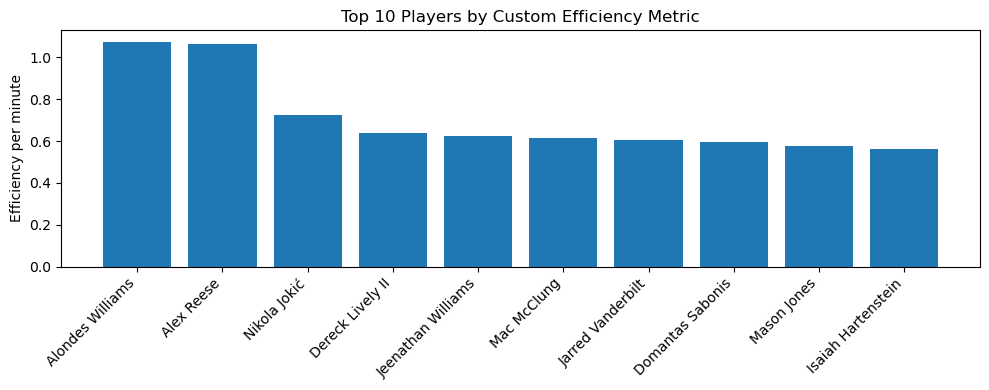

Top-10 efficiency plot saved to plots/top10_efficiency.png


In [16]:
def analyze_player_efficiency(df):
    print("\n ___________ BONUS PART: Player Efficiency Analysis ___________")
    df = df.copy()

    needed = ['Player', 'PTS', 'TRB', 'AST', 'STL', 'BLK',
              'FGA', 'FGM', 'FTA', 'FTM', 'TOV', 'MP']
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print("Missing columns for full efficiency metric:", missing)
        print("Will use only columns that exist.")

# keep only existing columns
    cols_for_group = [c for c in needed if c in df.columns]
    if 'Player' not in cols_for_group:
        print("No Player column – cannot do per-player efficiency.")
        return df

# Per-player averages
    eff_df = df.groupby('Player', as_index=False)[cols_for_group[1:]].mean()

# Custom efficiency metric:
# Eff = (PTS + TRB + AST + STL + BLK) - missed FG - missed FT - TOV
    pts = eff_df.get('PTS', 0)
    trb = eff_df.get('TRB', 0)
    ast = eff_df.get('AST', 0)
    stl = eff_df.get('STL', 0)
    blk = eff_df.get('BLK', 0)
    fga = eff_df.get('FGA', 0)
    fgm = eff_df.get('FGM', 0)
    fta = eff_df.get('FTA', 0)
    ftm = eff_df.get('FTM', 0)
    tov = eff_df.get('TOV', 0)

    missed_fg = (fga - fgm)
    missed_ft = (fta - ftm)

    eff_df['Raw_Eff'] = (
        pts + trb + ast + stl + blk
        - missed_fg
        - missed_ft
        - tov
    )

# Efficiency per minute
    if 'MP' in eff_df.columns:
        eff_df['Eff_per_min'] = eff_df['Raw_Eff'] / eff_df['MP'].replace(0, np.nan)
        eff_df['Eff_per_min'] = eff_df['Eff_per_min'].replace([np.inf, -np.inf], np.nan).fillna(0)
    else:
        eff_df['Eff_per_min'] = eff_df['Raw_Eff']

# Merge extra engineered metrics if present
    for extra in ['Shooting_Eff', 'ATR', 'Usage_Rate']:
        if extra in df.columns:
            extra_avg = df.groupby('Player', as_index=False)[extra].mean()
            eff_df = eff_df.merge(extra_avg, on='Player', how='left')

    eff_df_sorted = eff_df.sort_values('Eff_per_min', ascending=False).reset_index(drop=True)

    print("\nTop 10 players by custom efficiency per minute:")
    cols_to_show = ['Player', 'Eff_per_min', 'Raw_Eff']
    for c in ['Shooting_Eff', 'ATR', 'Usage_Rate']:
        if c in eff_df_sorted.columns:
            cols_to_show.append(c)
    display(eff_df_sorted[cols_to_show].head(10))

# Bar plot for top 10
    top10 = eff_df_sorted.head(10)
    plt.figure(figsize=(10, 4))
    plt.bar(top10['Player'], top10['Eff_per_min'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Efficiency per minute')
    plt.title('Top 10 Players by Custom Efficiency Metric')
    plt.tight_layout()
    plt.savefig('plots/top10_efficiency.png')
    plt.show()
    print("Top-10 efficiency plot saved to plots/top10_efficiency.png")

    return eff_df_sorted


efficiency_df = analyze_player_efficiency(df_feat)


#### A custom player efficiency metric was designed to evaluate performance beyond the provided GmSc by combining offensive, defensive, and playmaking contributions. Points, rebounds, assists, steals, and blocks were included because they directly increase team success, while turnovers and missed scoring opportunities represent wasted possessions and were therefore penalized when data was available.

#### To ensure fair comparison between players with different playing times, the efficiency score was normalized by minutes played (efficiency per minute). This highlights highly impactful bench players as well as consistent starters.

#### While the metric captures multiple performance dimensions, it does not adjust for player position or opponent strength, which could be considered in future improvements.